In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sys
from time import time
from utils import*

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from gensim.models import word2vec
from gensim.utils import tokenize
import nltk.data
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
import re 

In [3]:
#nltk.download('popular')

# 1.Load data

Text(0, 0.5, 'Number of job postings')

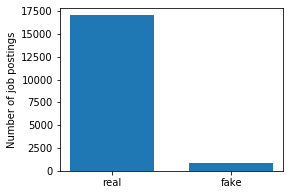

In [4]:
dataframe = pd.read_csv('fake_job_postings.csv')

counts = dataframe.fraudulent.value_counts()
width = 0.7
plt.figure(figsize=(4,3))
plt.bar(['real','fake'],counts,width)
plt.ylabel('Number of job postings')

### All data preview

In [5]:
print('shape: ',dataframe.shape)
series_names = list(dataframe.columns.values) 
data_top = dataframe.head()
data_top

shape:  (17880, 18)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


### Fake data preview

In [6]:
fake_ids = np.where(dataframe['fraudulent']==1)
fake_data = dataframe.iloc[fake_ids]
real_ids = np.where(dataframe['fraudulent']==0)
real_data = dataframe.iloc[real_ids]
fake_data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
98,99,IC&E Technician,"US, , Stocton, CA",Oil & Energy,95000-115000,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abilitie...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1
144,145,Forward Cap.,NaN,NaN,NaN,NaN,The group has raised a fund for the purchase o...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,1
173,174,Technician Instrument & Controls,US,Power Plant & Energy,NaN,Edison International and Refined Resources hav...,Technician Instrument &amp; ControlsLocation D...,JOB QUALIFICATIONS-Ability to understand proce...,"we are a team of almost 8,000 employees who he...",0,1,1,Full-time,Mid-Senior level,Certification,Electrical/Electronic Manufacturing,Other,1
180,181,Sales Executive,"PK, SD, Karachi",Sales,NaN,NaN,Sales Executive,Sales Executive,Sales Executive,0,0,0,NaN,NaN,NaN,NaN,Sales,1
215,216,IC&E Technician Mt Poso,"US, CA, Bakersfield, CA / Mt. Poso",Oil & Energy,95000-115000,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abiliti...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1


## 1.1 Data Exploration
### Analyze if the NaNs (missing values) are more represented in fake postings
Intuitively and by having a glance at the fake postings preview, the missing values are something that must help to detect if a posting is real or fake. Let's study their distribution across data to verify this hypothesis.

Proportion of fakes in missing values/Columns: 
[ 5.81039755  4.82026144  4.47491127 21.57295112  6.06060606  5.31697342
  7.46130031  6.57596372  5.89234387  5.94209162  5.50833606]
company_profile : 21.57 %


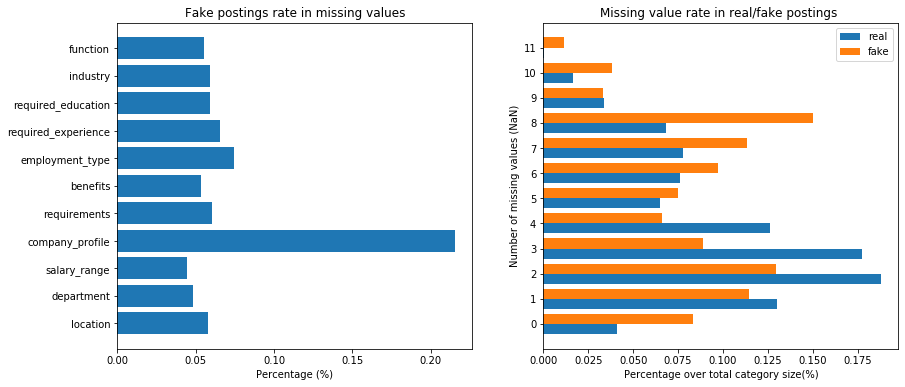

In [7]:
#Analyze if the NaNs (missing values) are more represented in fake postings
real_counts, fake_counts, nan_prop_fake, feat_with_nans = process_nans(fake_data, real_data, dataframe, series_names)
        
print('Proportion of fakes in missing values/Columns: ')
print(np.array(nan_prop_fake)*100)
print(series_names[5],':', round(max(nan_prop_fake)*100,2),"%")

fig, ax = plt.subplots(1,2,figsize=(14,6))
ax[0].barh(feat_with_nans, np.asarray(nan_prop_fake))
ax[0].set_title('Fake postings rate in missing values')
ax[0].set_xlabel('Percentage (%)')

width = 0.4
ax[1].barh(np.arange(len(real_counts))-width/2, np.asarray(real_counts), width, label='real')
ax[1].barh(np.arange(len(fake_counts))+width/2, np.asarray(fake_counts), width, label='fake')
ax[1].set_title('Missing value rate in real/fake postings ')
ax[1].set_xlabel('Percentage over total category size(%)')
ax[1].set_ylabel('Number of missing values (NaN)')
ax[1].set_yticks(range(len(fake_counts)))
ax[1].legend()

**Observations:**<br>
-  left plot: shows that, **if the 'company_profile' feature is missing in a posting, then the probability to be a fake is 20%**, which is very high compared to the other column features. Therefore the NaNs could be accounted for as text in the NLP method so that the classifier sees it. Another way can be to use this information as a prior to combine it with the class probability returned by the classifier if there is one. The final probability or prediction would be determined by weighted average or bayesian probabilities for instance.
<br> <br>
- right figure: is an histogram that represents the proportion of missing values that can be found in a single posting (fake or real). Clearly there is more chance that a fake posting has more missing values than a real one. Having $n$ missing values means that $n$ features are missing for this posting.
<br> <br>
NaNs represent therefore significant information to characterize fake postings

<a id="word_dist"></a>
### Analyze number of words distribution across classes  
The length of the word sequence can be very different across column features. It is interesting to check that distribution to see afterwards if the feature average length is correlated with the classification capability. 

In [15]:
list_feat = [0,9,10,11,17] #indices of numerical feature cols

#list numerical categories
num_series = [series_names[i] for i in list_feat]
print('_'*80)
print('Numerical features:')
print(num_series)

#list text categories
text_list = [elem for elem in range(1,17) if elem not in list_feat] 
text_series = [series_names[i] for i in text_list]
print('_'*80)
print('Text features:')
print(text_series)

________________________________________________________________________________
Numerical features:
['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']
________________________________________________________________________________
Text features:
['title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']


In [9]:
#average number of words per category and per posting
words_pcat_real = []
words_pcat_fake = []
for i in range(len(text_series)):
    serie = text_series[i]
    word_count_fake = fake_data[serie].str.split(expand=True).stack().value_counts()
    word_count_real = real_data[serie].str.split(expand=True).stack().value_counts()
    words_pcat_fake.append(word_count_fake.sum()/fake_data[serie].count())
    words_pcat_real.append(word_count_real.sum()/real_data[serie].count())

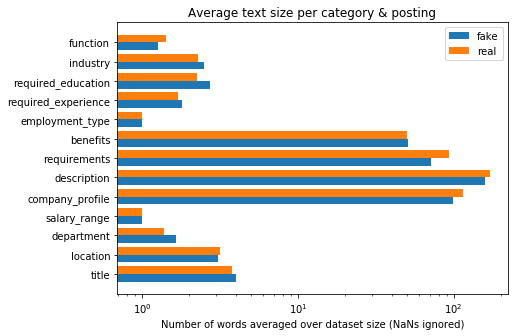

In [10]:
width = 0.4
fig,ax = plt.subplots(figsize=(7,5))
ax.barh(np.arange(len(text_series))-width/2, words_pcat_fake, width, log=True,label='fake')
ax.barh(np.arange(len(text_series))+width/2, words_pcat_real, width, log=True,label='real')
ax.set_title('Average text size per category & posting')
ax.set_xlabel('Number of words averaged over dataset size (NaNs ignored)')
ax.set_yticklabels(text_series)
ax.set_yticks(np.arange(len(text_series)))
ax.legend()

plt.show()

The number of words per posting or feature is homogeneous with respect to the classes, which is good. There are 4 feature columns that have significantly more average words per posting than the others: *'benefits'*, *'requirements'*, *'description'*, and *'company profile'*. <br>The more words, the more probability that the words in fake postings will be different of the real postings ones. <br>It is unlikely that "single word" features like *'employment type'*, that could be categorized by the way, contain discriminative information on the nature of the posting.

## 1.2 Split dataset in train/test set

A simple split with ```train_test_split()``` sklearn method. The **data is unbalanced**, therefore some precautions must be taken. <br>
Requirements: <br>
- Most of the minority class samples have to be in the train set
- This method applies a Stratified Kfold to preserve the same class proportions from original dataset in both subsets
- The number of real samples in train set isn't very important, as long as it is big enough.
<br><br>
>**Keeping the data unbalanced makes sense** because in a realistic situation it will be unbalanced as fake postings represent a minority of the overall postings published around the world. Training a classifier for this scenario is thus good. 
<br>
An alternative is to apply up or dowm-sampling advanced methods like Tomek links or SMOTE by using the imblearn library

In [11]:
y = dataframe['fraudulent']
test_rate = 0.2
X_train, X_test, y_train, y_test = simple_split(dataframe, y, test_rate)

fake class rate in train: 0.05 / test: 0.05
Proportion of total fakes in train set: 0.8 



# 2. Preprocessing

The preprocessing includes:
- feature extraction, i.e. select only text data because the focus is on applying NLP techniques
- clean data: eventually helps to improve performance. Replace NaNs, remove stopwords, etc. Reshape the text in other format, e.g. list of lists. 
- merge features columns by aggregation
- define functions to vectorize and tokenize the text data, thereby most frequent words in postings, features, and classes can be computed.
- feature selection : once the data is vectorized, the data matrix can be huge and statistical tests help to reduce the size by keeping only the bests.


See `utils.py` for more details on the implementations (most aren't displayed nor used in this section)

Note: Usually PCA is applied as a preprocessing step for any kind of ML problem to reduce dimensionality and remove low variance features, thus serves as well as a feature selection tool. For NLP it doens't turn out to be a common practice though. PCA helps in many cases to better separate data by making clusters appear.

### Remove numerical data from dataset (only text)

In [12]:
# keep only text  feature columns
Xtxt_train = get_txt_data(X_train, num_series)
Xtxt_test = get_txt_data(X_test, num_series)
print("Train set size (num data ignored): ", Xtxt_train.shape)
print("Test set size (num data ignored): ", Xtxt_test.shape)

Train set size (num data ignored):  (14304, 13)
Test set size (num data ignored):  (3576, 13)


In [21]:
#Example of 3 merged feature columns 
categories = [text_series[0], text_series[1], text_series[2]]
Xmerg_train, Xmerg_test = generate_corpus(Xtxt_train, Xtxt_test, categories)
print(Xmerg_train.shape)
Xmerg_train.head()

(14304,)


2112     Operations Specialists-EE, 37, Tallinn-Operations
7571     Purolator International - Pricing Financial An...
764                   Account Manager-US, NY, Brooklyn-nan
17291    Immediate Opening : J2EE Developer for Bahrain...
16069    Senior Strategic Buyer - Supply Chain MS Offic...
dtype: object

In [22]:
n_most = 15
print('_'*80)
print('Fake data :')
get_most_freq_grams(fake_data, 'department', n_most)

________________________________________________________________________________
Fake data :
15 most frequent words (unigrams) in corpus: 

('engineering', 62)
('clerical', 32)
('energy', 30)
('oil', 28)
('technology', 28)
('information', 27)
('sales', 26)
('service', 23)
('customer', 23)
('administrative', 16)
('admin', 13)
('accounting', 11)
('center', 10)
('csr', 7)
('payroll', 7)


# 3. Bag of Words approach

First NLP technique applied on the data. `scikit-learn` library provides plenty of built-in tools to work with text using Bag of Word, therefore all this section relies on using methods from that very complete library.

The workflow consists  in trying different tokenizers on different feature columns from the original dataset. Then select the most promising ones according to a classifier. Apply grid search to optimize the hyperparameters of the chosen classifier, perform cross-validation to avoid unreliable results. Analyze sensitivity to feature selection and train set size.

- Only one classifier is used for the sake of showing a proof of concept
- Two tokenizers are used: `CountVectorizer()`and `TfidfTransformer()`
    - first is for counting the N-gram occurences and transforming it to numerical feature vectors
    - second deals with the discrepancies in the documents size producing artefacts, by transforming the vectors to frequency values. Values are thus relative to text size and features are weighted in case they occur in many documents.

## 3.1 Penalized classifier 

Applying weights on classes in response of the unbalanced data is an effective way to improve the results.
The classifier decision boundary line is thus shifted towards the majority class samples in order to discriminate better the data points.

<a id="sgd_classif"></a>
### Effect of balanced class weights on several metric for an SGD classifier (SVM)

Linear SVM classifiers appear to be one of the best among all for text classification tasks. Therefore we decide to use this one. The Stochastic Gradient Descent refers only to the optimizazion algoithm to find the minimum of the loss funtion but it provides also more parameters choices. Indeed, we use a 'modified huber' loss that deals better with outliers than the classic 'hinge' loss (it is a quadratic smoothed version). The param `alpha` is equivalent to the regular `C`. 

The goal is to find which columns feature are the most responsive in order to get rid of the other and merge them.

In [30]:
#define the parameters
n_gram_range = (1,2) #unigrams and bigrams
verbose = 0 #silent (no report, intermediary resutls, etc)
params = [n_gram_range, verbose] #ngrams_range, report disabled

In [50]:
#define the classifiers
clf_bld = SGDClassifier(loss='modified_huber',alpha=.0001, max_iter=50,
                    penalty="elasticnet",class_weight='balanced')
clf = SGDClassifier(loss='modified_huber',alpha=.0001, max_iter=50,
                    penalty="elasticnet",class_weight=None)


In [88]:
#compute balanced accu, F1-score and accuracy
#for each feature col individually
n_metrics = 3
bld_clf_scores = np.zeros((len(text_series),n_metrics)) #score for balanced class weights 
scores = np.zeros((len(text_series),n_metrics)) #regular score
info = False
for col_idx, col_name in enumerate(text_series):
    categories = [col_name]
    if info == True:
        print('_' * 80)
        print("Corpus: ")
        print(col_name)
    X1col_train, X1col_test =  generate_corpus(Xtxt_train, Xtxt_test, categories)
    scores[col_idx] = classify_data(clf, X1col_train, X1col_test, y_train, y_test, params)
    bld_clf_scores[col_idx] = classify_data(clf_bld, X1col_train, X1col_test, y_train, y_test, params)
    

SGD :
accu: 0.969   bld_accu: 0.730   f1: 0.600 

SGD :
accu: 0.940   bld_accu: 0.835   f1: 0.549 

SGD :
accu: 0.951   bld_accu: 0.545   f1: 0.163 

SGD :
accu: 0.807   bld_accu: 0.702   f1: 0.235 

SGD :
accu: 0.954   bld_accu: 0.570   f1: 0.241 

SGD :
accu: 0.936   bld_accu: 0.603   f1: 0.268 

SGD :
accu: 0.951   bld_accu: 0.527   f1: 0.102 

SGD :
accu: 0.927   bld_accu: 0.551   f1: 0.155 

SGD :
accu: 0.964   bld_accu: 0.641   f1: 0.440 

SGD :
accu: 0.842   bld_accu: 0.914   f1: 0.389 

SGD :
accu: 0.976   bld_accu: 0.762   f1: 0.688 

SGD :
accu: 0.983   bld_accu: 0.852   f1: 0.805 

SGD :
accu: 0.972   bld_accu: 0.726   f1: 0.619 

SGD :
accu: 0.835   bld_accu: 0.782   f1: 0.307 

SGD :
accu: 0.970   bld_accu: 0.707   f1: 0.581 

SGD :
accu: 0.601   bld_accu: 0.701   f1: 0.171 

SGD :
accu: 0.949   bld_accu: 0.500   f1: 0.000 

SGD :
accu: 0.151   bld_accu: 0.524   f1: 0.101 

SGD :
accu: 0.949   bld_accu: 0.500   f1: 0.000 



C:\Users\Pablo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGD :
accu: 0.604   bld_accu: 0.475   f1: 0.078 

SGD :
accu: 0.950   bld_accu: 0.513   f1: 0.053 



C:\Users\Pablo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGD :
accu: 0.429   bld_accu: 0.597   f1: 0.122 

SGD :
accu: 0.949   bld_accu: 0.500   f1: 0.000 



C:\Users\Pablo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGD :
accu: 0.539   bld_accu: 0.668   f1: 0.151 

SGD :
accu: 0.949   bld_accu: 0.500   f1: 0.000 

SGD :
accu: 0.478   bld_accu: 0.623   f1: 0.132 



C:\Users\Pablo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


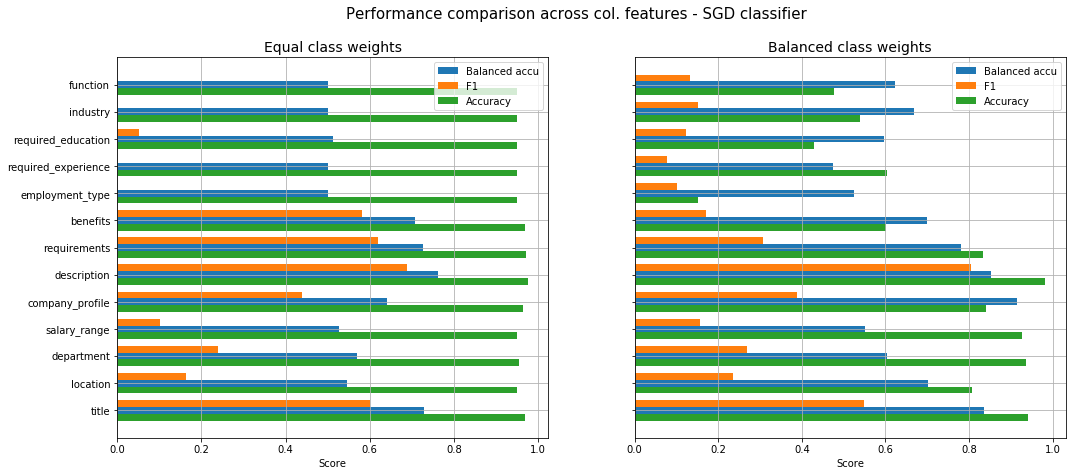

In [108]:
width = 0.25
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(17,7), sharey=True)
ax1.barh(np.arange(len(text_series)), scores[:,1], width,label='Balanced accu')
ax1.barh(np.arange(len(text_series))+width, scores[:,2], width, label='F1')
ax1.barh(np.arange(len(text_series))-width, scores[:,0], width, label='Accuracy')
ax1.set_title('Equal class weights',fontsize=14)
ax1.set_xlabel('Score')
ax1.set_yticklabels(text_series)
ax1.set_yticks(np.arange(len(text_series)))
ax1.legend()
ax1.grid()

ax2.barh(np.arange(len(text_series)), bld_clf_scores[:,1], width,label='Balanced accu')
ax2.barh(np.arange(len(text_series))+width, bld_clf_scores[:,2], width, label='F1')
ax2.barh(np.arange(len(text_series))-width, bld_clf_scores[:,0], width, label='Accuracy')
ax2.set_title('Balanced class weights',fontsize=14)
ax2.set_xlabel('Score')
ax2.legend()
ax2.grid()
fig.suptitle('Performance comparison across col. features - SGD classifier',fontsize=15)
plt.show()

- Accuracy is completely biased by the unbalancedness. **It shouldn't be used** to evaluate performance but it is useful to determine which class is misclassified the most as a confusion matrix could do.
- Balanced accuracy is a scoring metric that computes the average (arithmetic) accuracy between both classes. It is suited for unbalanced datasets as we can see. 
- F1 score is useful to see the capability to classifiy correctly the "positive class" being the fake one (label=1) by default
- **A good balanced accuracy and F1 score is the selection criterion**

**observations**:
-  clearly, applying weights proportional to the subset size to each class improves the results. It avoid that almost all real posting are correctly classified whereas the fakes ones not at all.
- it shows that there are 5 major promising column features in the orginal dataset: *'benefits'*, *'requirements'*, *'description'*, *'company profile'*, *'title'*. It is an interesting result because it matches quite well the average words per feature and posting figure in [data explo section](#word_dist) except for *'company profile'*. This feature is also highlighted in [data explo section](#word_dist).
- F1 scores are quite low except for the *'description'* feature which is unsatisactory. A good solution to improve that could be to  merge these 5 columns and redo the process.

## 3.2 Fine-tune classifier for a set of aggregated columns in original dataset (manual feat. sel.)

### Test some of most well performing columns with SGD classifier penalizing classes

In [50]:
#define the parameters
n_gram_range = (1,2)
verbose = 1
params = [n_gram_range, verbose] #ngrams_range, report disabled

In [41]:
# Combine feature columns (original dataset) into one 
categories = ['title','company_profile','description','benefits','requirements']
Xcol_train, Xcol_test =  generate_corpus(Xtxt_train, Xtxt_test, categories)

In [53]:
scores = classify_data(clf_bld, Xcol_train, Xcol_test, y_train, y_test, params)
print('Aggregated series/cols: \n', categories)
print('Classifier: SGD with modified hubber loss and elasticnet penalty')

________________________________________________________________________________
Vectorizing: 
Number of features: 947647
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=50, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)
train time: 1.336s
test time:  0.008s
SGD :
accu: 0.989   bld_accu: 0.913   f1: 0.888 

top 10 determining keywords/features 
money ;clerical ;data entry ;subsea ;earn ;link ;nan apply ;line requirements ;apply using ;using link

classification report:
               precision    recall  f1-score   support

real postings     

### Optimize the hyper parameters through grid search
We only try a few hyperparameters combinations because Grid Search is a very heavy and time consuming method.

In [24]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer(sublinear_tf=True)),
    ('clf', SGDClassifier(loss='modified_huber', max_iter=50,
                          penalty="elasticnet", class_weight='balanced'))
     ])

parameters = {'clf__alpha': (1e-03, 1e-04, 1e-05), #C parameter of linear SVM
 'tfidf__use_idf': (True, False), #enable/disable tf-idf transformation
 'vect__ngram_range':  ((1, 1),(1,2),(1,3)), #ngram combination
 'vect__max_df': (0.5, 0.75),} #max autorized frequency threshold 

grid_search = GridSearchCV(pipeline, parameters, scoring='balanced_accuracy',n_jobs=-1, verbose=1, cv=2)
grid_search.fit(Xcol_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 10.2min finished


Best score: 0.936
Best parameters set:
	clf__alpha: 1e-05
	tfidf__use_idf: True
	vect__max_df: 0.75
	vect__ngram_range: (1, 3)


### Compute the scores stats for the best parameters using a 5-fold CV

In [42]:
best_params = [(1,3),0,0.75] #ngrams, disable report, max_df
best_clf = SGDClassifier(loss='modified_huber',alpha=1e-5, max_iter=50,
                    penalty="elasticnet",class_weight='balanced')

Xvec_train, Xvec_test, feat_names = vectorize(Xcol_train, Xcol_test, best_params) 
scores = cross_val_score(best_clf, Xvec_train, y_train, cv=5, scoring='balanced_accuracy')

print('TFID Vectorizer: n-grams range:(1,3)/ max_df=0.75')
print('SGD Classif: mod. hubber/ elastic/ C=1e-5')
print("Balanced_accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

TFID Vectorizer: n-grams range:(1,3)/ max_df=0.75
SGD Classif: mod. hubber/ elastic/ C=1e-5
Balanced_accuracy: 0.92 (+/- 0.04)


## 3.3 Univariate feature selection with $\chi^{2}$
**Test if dimensionality reduction helps to improve the results.** Only the K-best features (statistical test) are kept.<br>
Use same train/test set than above

In [109]:
categories = ['title','company_profile','description','benefits','requirements']
Xagg_train, Xagg_test =  generate_corpus(Xtxt_train, Xtxt_test, categories)

In [110]:
best_clf = SGDClassifier(loss='modified_huber',alpha=1e-5, max_iter=50,
                         penalty="elasticnet",class_weight='balanced')

In [111]:
n_best = 100
n_gram_range = (1,3)
verbose = 1 #enabled text prints
max_df = 0.75
params = [n_gram_range, verbose, max_df]
#Xvec_train, Xvec_test, feature_names = vectorize(clean_trainset.posting, clean_testset.posting, params) 
Xvec_train, Xvec_test, feature_names = vectorize(Xagg_train, Xagg_test, params) 
Xch2_train, Xch2_test = vectorize_ch2(Xvec_train, Xvec_test, y_train, feature_names, n_best)

________________________________________________________________________________
Vectorizing: 
Number of features: 2393711
Extracting 100 best features by a chi-squared test

['________________________________________don', '________________________________________don let', '________________________________________don let opportunity', 'accepting online', 'accepting online applications', 'access internet', 'access internet participate', 'aker', 'aker solutions', 'applications onlyclick', 'applications onlyclick apply', 'aptitude staffing', 'available started', 'available started right', 'candidates encouraged', 'complete training provided', 'computer internet', 'data entry', 'data entry complete', 'design technology bring', 'discoveries production', 'discoveries production maximize', 'doing data', 'doing data entry', 'earn', 'easy start', 'easy start ________________________________________don', 'employ approximately 28', 'engineering design technology', 'entry complete', 'entry complet

In [112]:
#performs n_runs (fitting and predict) to have a reliable idea of the ch2 method results
n_runs = 100
n_metrics = 3
chi2_scores = np.zeros((n_runs, n_metrics))
for i in range(n_runs):
    best_clf.fit(Xch2_train, y_train)
    preds = best_clf.predict(Xch2_test)
    chi2_scores[i] = compute_clf_scores([preds], ['SGD'],y_test)  


SGD :
accu: 0.942   bld_accu: 0.734   f1: 0.468 

SGD :
accu: 0.949   bld_accu: 0.738   f1: 0.501 

SGD :
accu: 0.942   bld_accu: 0.734   f1: 0.465 

SGD :
accu: 0.949   bld_accu: 0.738   f1: 0.500 

SGD :
accu: 0.941   bld_accu: 0.734   f1: 0.463 

SGD :
accu: 0.947   bld_accu: 0.737   f1: 0.489 

SGD :
accu: 0.941   bld_accu: 0.734   f1: 0.463 

SGD :
accu: 0.935   bld_accu: 0.731   f1: 0.441 

SGD :
accu: 0.941   bld_accu: 0.734   f1: 0.463 

SGD :
accu: 0.943   bld_accu: 0.734   f1: 0.470 

SGD :
accu: 0.953   bld_accu: 0.740   f1: 0.521 

SGD :
accu: 0.951   bld_accu: 0.739   f1: 0.510 

SGD :
accu: 0.954   bld_accu: 0.740   f1: 0.523 

SGD :
accu: 0.951   bld_accu: 0.739   f1: 0.508 

SGD :
accu: 0.951   bld_accu: 0.739   f1: 0.510 

SGD :
accu: 0.950   bld_accu: 0.738   f1: 0.503 

SGD :
accu: 0.950   bld_accu: 0.738   f1: 0.506 

SGD :
accu: 0.950   bld_accu: 0.738   f1: 0.503 

SGD :
accu: 0.949   bld_accu: 0.738   f1: 0.499 

SGD :
accu: 0.945   bld_accu: 0.736   f1: 0.483 



(100, 3)


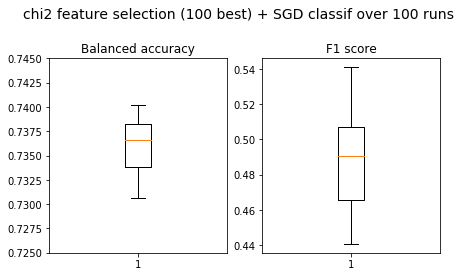

In [126]:
print(chi2_scores.shape)
fig = plt.figure(figsize=(7,4))
plt.subplot(121)
plt.boxplot(chi2_scores[:,1])
plt.ylim(0.725,0.745)
plt.title('Balanced accuracy')
plt.subplot(122)
plt.boxplot(chi2_scores[:,2])
plt.title('F1 score')
fig.suptitle('chi2 feature selection (%d best) + SGD classif over %d runs' % (n_best,n_runs),
            fontsize=14)
fig.subplots_adjust(top=0.8)

$\chi^{2}$ feature selection is quite disappointing in terms of final classification performance. It remains useful to fasten the process by reducing the comput. cost. 

The variance of the F1 score is surprisingly high for a 100 run test and may be abnormal.
**Text classification looks to work better by keeping all the features**

## 3.4 Sensitivity to train set size
Check how the train set size affects the results.<br>
Test set remains the same as before (otherwise comparison not possible).<br>
Train set is randomly sampled from the previous one: 5 merged columns.<br>
No feature selection.
No optimized classifier, just the defined one at the beginning of [the section](#sgd_classif)

In [49]:
(y_train[Xcol_train.index.values)

685

In [58]:
params = [(1,2),0,0.75]
nb_splits = 20 #number of train set splits or samplings
n_metrics = 3
split_rates = np.linspace(0.1,1,nb_splits)
fake_rate = []
scores = np.zeros((nb_splits, n_metrics))
for cnt, rate in enumerate(split_rates):
    print(cnt)
    Xsamp_train =  Xcol_train.sample(frac=rate,random_state=42)
    ys_train = y_train[Xsamp_train.index.values]
    print(Xsamp_train.shape)
    print(ys_train.shape)

    scores[cnt] = classify_data(clf_bld, Xsamp_train, Xcol_test, ys_train, y_test, params)
print(scores)

0
(1430,)
(1430,)
SGD :
accu: 0.936   bld_accu: 0.835   f1: 0.533 

1
(2108,)
(2108,)
SGD :
accu: 0.972   bld_accu: 0.815   f1: 0.697 

2
(2786,)
(2786,)
SGD :
accu: 0.975   bld_accu: 0.838   f1: 0.738 

3
(3463,)
(3463,)
SGD :
accu: 0.968   bld_accu: 0.860   f1: 0.703 

4
(4141,)
(4141,)
SGD :
accu: 0.979   bld_accu: 0.850   f1: 0.776 

5
(4818,)
(4818,)
SGD :
accu: 0.983   bld_accu: 0.873   f1: 0.819 

6
(5496,)
(5496,)
SGD :
accu: 0.985   bld_accu: 0.887   f1: 0.837 

7
(6173,)
(6173,)
SGD :
accu: 0.987   bld_accu: 0.901   f1: 0.859 

8
(6851,)
(6851,)
SGD :
accu: 0.987   bld_accu: 0.902   f1: 0.864 

9
(7528,)
(7528,)
SGD :
accu: 0.987   bld_accu: 0.904   f1: 0.867 

10
(8206,)
(8206,)
SGD :
accu: 0.990   bld_accu: 0.924   f1: 0.898 

11
(8884,)
(8884,)
SGD :
accu: 0.987   bld_accu: 0.910   f1: 0.869 

12
(9561,)
(9561,)
SGD :
accu: 0.989   bld_accu: 0.913   f1: 0.880 

13
(10239,)
(10239,)
SGD :
accu: 0.989   bld_accu: 0.921   f1: 0.887 

14
(10916,)
(10916,)
SGD :
accu: 0.987   b

Text(0.5, 0, 'Fraction of initial train set (14304 samples)')

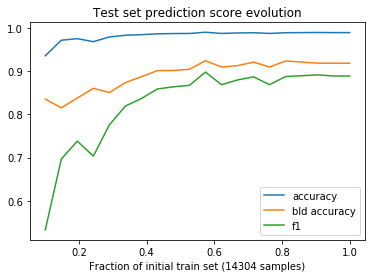

In [62]:
plt.figure()
plt.plot(split_rates,scores[:,0],label='accuracy')
plt.plot(split_rates,scores[:,1],label='bld accuracy')
plt.plot(split_rates,scores[:,2],label='f1')
plt.title('Test set prediction score evolution')
plt.legend()
plt.xlabel('Fraction of initial train set (14304 samples)')

Accuracy isn't almost sensitive at all to the train set size which confirms that it is a bad measure. <br>
We see that a plateau is reached from about 60% of the initial train set meaning that we could decrease the number of training samples and keep the same performance which is a good insight.<br>
The oscillation are due to the varying number of 'fake' samples that affect the classifier a lot. Therefore the sampling could be improved

# 4. Word2Vec Embedding approach

## 4.1 Train own model
Use same corpus as before, i.e. the five aggregated columns gathered in Xcol_train/test.<br>
First try only for the descritpion column.<br> <br>
Word2Vec accounts for the words order in a sequence, therefore captures the semantics of the textual data. It doesn't mean it will perform better, this depends on the task and the classification problem, also a fine-tuning and huge pre-trained model are helpful to improve performance. The bigger the model the more powerful it is as it learns from many more context combinations. This is why pre-trained models are often used (GloVe, Google, Wikipedia), yet the drawback is they may not be specialized in a certain type of vocabulary.

### Preprocessing of the sentences for each posting
Remove undesired text sequences such as html tags, non existing words, or common words not carrying meaningful information. <br> The data is gathered in a list of lists format suited for the model creation method

In [11]:
# Feature column names to combine/aggregate
categories = ['title','company_profile','description','benefits','requirements']
# Aggregate columns corresponding to the above feature categories in one column
Xagg_train, Xagg_test =  generate_corpus(Xtxt_train, Xtxt_test, categories)

In [12]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

sentences = []
print("Parsing sentences from training set")
for posting in Xagg_train:
    sentences += posting_sentences(posting, tokenizer)

Parsing sentences from training set


C:\Users\Pablo\Anaconda3\lib\site-packages\bs4\__init__.py:314: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


### Create w2v model from our dataset
No fine tuning of hyper parameters for this method because too demanding <br>
Much less features are used than for the bag of words approach (dimensionality reduction) <br>
CBOW (Continuous Bag of Words), i.e. the default algorithm, is used even though Skip-gram may produce better results<br>
<br>
The models can be saved, here only the last one tried for the same 5 feature cols used in **3.** is displayed 

In [180]:
# Creating the model and setting values for the various parameters
num_features = 300  # Word vector dimensionality
min_word_count = 40 # Minimum word count
num_workers = 4     # Number of parallel threads
context = 10        # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

# Initializing the train model
print("Training model....")
model = word2vec.Word2Vec(sentences,\
                          workers=num_workers,\
                          size=num_features,\
                          min_count=min_word_count,\
                          window=context,
                          sample=downsampling)

# To make the model memory efficient
model.init_sims(replace=True)

# Saving the model for later use. Can be loaded using Word2Vec.load()
#model_name = "300features_40minwords_10context"
model_name = "300features_40minwords_10context_BestCols"
model.save(model_name)

Training model....


In [181]:
#few tests to see if the model is consistent
model.wv.doesnt_match("cali US Texas europe ".split())

C:\Users\Pablo\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'europe'

In [182]:
model.wv.most_similar("executive")

[('director', 0.6236939430236816),
 ('vice', 0.6020326614379883),
 ('executives', 0.5751060247421265),
 ('president', 0.574233889579773),
 ('manager', 0.546119213104248),
 ('vp', 0.5427366495132446),
 ('directors', 0.5400621891021729),
 ('senior', 0.525533139705658),
 ('coordinator', 0.5052340030670166),
 ('consultant', 0.504036545753479)]

### Averaging the postings word sequence with the model
Buil the train and test set by averaging all the word embeddings in each posting using the model (lookup table)

In [271]:
# Calculating average feature vector for training set
clean_train_postings = []
#for description in Xtxt_train['description']:
for description in Xagg_train:
    clean_train_postings.append(posting_wordlist(description))
    
trainDataVecs = getAvgFeatureVecs(clean_train_postings, model, num_features)

Posting 0 of 14304


C:\Users\Pablo\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


Posting 1000 of 14304
Posting 2000 of 14304
Posting 3000 of 14304
Posting 4000 of 14304
Posting 5000 of 14304
Posting 6000 of 14304
Posting 7000 of 14304
Posting 8000 of 14304
Posting 9000 of 14304
Posting 10000 of 14304
Posting 11000 of 14304
Posting 12000 of 14304
Posting 13000 of 14304
Posting 14000 of 14304


In [274]:
# Calculating average feature vactors for test set     
clean_test_postings = []
#for description in Xtxt_test['description']:
for description in Xagg_test:
    clean_test_postings.append(posting_wordlist(description))
    
testDataVecs = getAvgFeatureVecs(clean_test_postings, model, num_features)

Posting 0 of 3576


C:\Users\Pablo\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


Posting 1000 of 3576
Posting 2000 of 3576
Posting 3000 of 3576


###  Train and compare different classifiers 
The classifier that was the best for Bag of Words is not necessarly the best for Word2Vec embedding. <br>
In order to compare the 2 approaches, we use the same metrics.
The idea of using different metrics makes sense because a single one isn't enough to correctly evaluate if a classifier performs well. Indeed, balanced accuracy doesn't tell which class is the one that is the most misclassified as could a confusion matrix do, therefore by looking at the standard accuracy (**biased**), we can guess.

In [275]:
# Fitting different classifiers to the training data
forest_clf = RandomForestClassifier(n_estimators = 100)

sgd_clf = SGDClassifier(loss='modified_huber',alpha=1e-5, max_iter=100,
                        penalty="elasticnet",class_weight='balanced')

adaboost_clf = AdaBoostClassifier(n_estimators=100, random_state = 1)
 
print('Train set shape: ',trainDataVecs.shape)   
print("Fitting random forest to training data....")    
forest = forest_clf.fit(trainDataVecs, y_train)
print("Fitting SGD classifier (SVM) to training data....")    
lin_svm = sgd_clf.fit(trainDataVecs, y_train)
print("Fitting Ada Boost classifier to training data....")    
adaboost = adaboost_clf.fit(trainDataVecs, y_train)

Train set shape:  (14304, 300)
Fitting random forest to training data....
Fitting SGD classifier (SVM) to training data....


C:\Users\Pablo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Fitting Ada Boost classifier to training data....


In [276]:
# Predicting the sentiment values for test data and saving the results in a csv file 
pred_forest = forest_clf.predict(testDataVecs)
pred_sgd = sgd_clf.predict(testDataVecs)
pred_adaboost = adaboost_clf.predict(testDataVecs)
#output = pd.DataFrame(data={"id":X_test['job_id'], "fraudulent":result})
#output.to_csv( "output.csv", index=False, quoting=3 )

In [278]:
# Compute scoring metrics for all the classifiers
preds = [pred_forest, pred_sgd, pred_adaboost]
clf_names = ['forest','SGD (linear svm)','Ada Boost (ensemble)']
scores_w2v = compute_clf_scores(preds, clf_names, y_test)

forest :
accu: 0.971   bld_accu: 0.718   f1: 0.605 

SGD (linear svm) :
accu: 0.759   bld_accu: 0.836   f1: 0.279 

Ada Boost (ensemble) :
accu: 0.967   bld_accu: 0.747   f1: 0.609 



In [279]:
#np.save('scores_w2v_5col',scores_w2v)

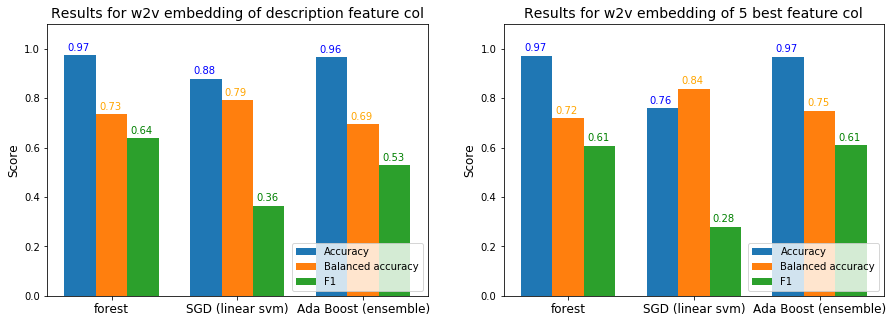

In [129]:
# Plot the scores for the tested classifiers and training data
scores_w2v_descri = np.load('scores_w2v_DescriCol.npy')
scores_w2v_5col = np.load('scores_w2v_5col.npy')
clf_names = ['forest','SGD (linear svm)','Ada Boost (ensemble)']
    
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharey=False)
plot_scores(ax1, scores_w2v_descri, clf_names,'description')
plot_scores(ax2, scores_w2v_5col, clf_names,'5 best')


- We observe that using more than one feature column doesn't improve significantly the results. 
- Adaboost and Random forest give similar results and are better than the SGD classifier previously used in the bag of words approach. SGD is makes a lot misclaffication errors for both classes leading to a poor F1 score
- SGD classifier with 5 features cols, even though it has the highest balanced accuracy score, can't be considered the best because of it's low F1 score
- The scores are only obtained from a single run, thus the variance isn't accounted for. This could be improved by making several runs. However it won't change the trend: this implementation of word2vec doesn't give good results overall
- Other columns combinations could be tried as well as other hyperparameters
- Using a pre-trained model could also improve the results

# 5. Conclusions

## 5.1 Comparison of both approaches

The Bag of Words approach turns out to be the best one despite its limitation: it doesn't account for word context nor order. It proves therefore that context isn't necessary for every text classification. The results are roughly the following: <br>

**Bag of Words balanced accu: 0.92** <br>
**Word2Vec balanced accu: 0.80** <br>

The difference is huge. A major factor is dimensionnality reduction (**BoW:>$10^6$ dim vs. w2v:300 dim**). Indeed the more features, the better the score. 
Word2Vec model wasn't studied as deeply as the other one and it can be further improved. Once a model is built with Word2Vec it is very handy to reuse it for different tasks which is not the case for our bag of words implementation.<br>

A linear SVM represents a very good classif for BoW but not for w2v. 



## 5.2 Future improvements
- use area under curve of ROC as evaluation metric: suited for unbalanced labels. Needs the classifier output probabilities for each sample, which is an available information with SGD clf.   
- Try Doc2Vec, Fast Text embeddings
- Use a pre-trained w2v model such as GloVe
- Try other columns combination, leverage the numerical data, other feature selection methods
- Performs several runs and average them in the first part of BoW. Each time the classif is used it converges to a similar but different value (non convex problem --> sensitive to initial conditions)

# References

- Word2vec <br>
http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/ <br>
https://www.kaggle.com/ananyabioinfo/text-classification-using-word2vec/notebook <br>
https://www.kaggle.com/varun08/sentiment-analysis-using-word2vec/notebook <br>
http://www.xavierdupre.fr/app/papierstat/helpsphinx/notebooks/text_sentiment_wordvec.html#reduire-les-dimensions-avec-une-acp <br>
https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92  <br>
https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/ipynb_with_output/Document%20classification%20with%20word%20embeddings%20tutorial%20-%20with%20output.ipynb
<br>
- Bag of Words <br>
https://towardsdatascience.com/nlp-learning-series-part-2-conventional-methods-for-text-classification-40f2839dd061

- General ML tools <br>
https://scikit-learn.org/stable/user_guide.html <br>
https://scikit-learn.org/stable/modules/classes.html <br>
https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb <br>
https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets <br>
https://elitedatascience.com/imbalanced-classes <br>